https://www.usitc.gov/data/gravity/gme_docs/estimation_tutorial/

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import matplotlib.pyplot as plt 

import statsmodels.api as sm
from scipy import stats

In [23]:
gravd = pd.read_csv('/content/gdrive/MyDrive/gravity/gravd.csv')
gravd.columns

Index(['year', 'iso_o', 'iso_d', 'contig', 'comlang_off', 'distw', 'pop_o',
       'gdp_o', 'gdpcap_o', 'iso2_o', 'pop_d', 'gdp_d', 'gdpcap_d', 'iso2_d',
       'heg_d', 'conflict', 'indepdate', 'heg_o', 'col_to', 'col_fr',
       'col_hist', 'col_cur', 'sever', 'sib_conflict', 'gatt_o', 'gatt_d',
       'rta', 'comleg', 'comcur', 'acp_to_eu', 'gsp', 'eu_to_acp', 'gsp_rec',
       'flow', 'validmirror', 'family', 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [24]:
gravd = gravd[['flow', 'distw'
                     , 'gdp_o', 'gdp_d'
                     , 'contig', 'comlang_off', 'col_hist'
                     , 'isl_o', 'isl_d', 'lndl_o', 'lndl_d'
                     ]]
gravd = gravd.dropna()

In [25]:
flow = np.array(gravd.flow.astype(np.float32))  
print('of', len(flow), 'observations'
      , len(flow) - np.count_nonzero(flow), ' are zero ='
      , (len(flow) - np.count_nonzero(flow))/ len(flow)*100, '%')

of 26967 observations 6970  are zero = 25.846404865205624 %


In [26]:
bins = np.geomspace(1, len(gravd), 100)
flowZ = flow.copy()
flowZ = np.digitize(flow, bins)

In [27]:
# weighted geographical between origin and destination
distw = np.log(np.array(gravd.distw.astype(np.float32)))

# GDP of origin
gdp_o = np.log(np.array(gravd.gdp_o.astype(np.float32)))

# GDP of destination
gdp_d = np.log(np.array(gravd.gdp_d.astype(np.float32)))

# Dummies 
# neighbourhood status between origin and destination
contig = np.array(gravd.contig.astype(np.int8))
# common official language of origin and destination
comlang_off = np.array(gravd.comlang_off.astype(np.int8))
# colonial ties between origin and destination
col_hist = np.array(gravd.col_hist.astype(np.int8))
# island
isl_o = np.array(gravd.isl_o.astype(np.int8))
isl_d = np.array(gravd.isl_d.astype(np.int8))
# landlocked
lndl_o = np.array(gravd.lndl_o.astype(np.int8))
lndl_d = np.array(gravd.lndl_d.astype(np.int8))

X = np.array([flowZ, distw, gdp_o, gdp_d
              , contig, comlang_off, col_hist
              , isl_o, isl_d, lndl_o, lndl_d
              ]).T

In [28]:
# class for data preparation
class prepare_data:
    def __init__(self):
        self.X = X.copy()
        self.y = flow.copy()
        
    # train test split and transform
    def tts(self, rnd = 42):
         # train test split stratify on binary zero trade
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X[:,1:11], self.y
                                                                                , random_state=(rnd)
                                                                                , test_size=0.2
                                                                                , stratify=(self.X[:,0])
                                                                                )

In [33]:
data = prepare_data()
data.tts()

In [34]:
feature_names = gravd.columns[1:len(X[0,:])]
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

https://github.com/statsmodels/statsmodels/issues/4942
https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html
https://personal.lse.ac.uk/tenreyro/LGW.html?

In [35]:
mod = sm.GLM(data.y_train, data.X_train, family=sm.families.Poisson())

In [36]:
results = mod.fit(cov_type='HC1')
#results = mod.fit(cov_type='HC0')

In [37]:
# results = mod.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                21573
Model:                            GLM   Df Residuals:                    21563
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1565e+06
Date:                Sun, 16 May 2021   Deviance:                   6.2600e+06
Time:                        16:46:53   Pearson chi2:                 1.03e+07
No. Iterations:                     7                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0123      0.025    -40.667      0.0

In [38]:
feature_names

Index(['distw', 'gdp_o', 'gdp_d', 'contig', 'comlang_off', 'col_hist', 'isl_o',
       'isl_d', 'lndl_o', 'lndl_d'],
      dtype='object')

In [39]:
params = results.params

compute R2

In [40]:
predict_oos = mod.predict(params, data.X_test)
predict_wis = mod.predict(params, data.X_train)

cor_oos = np.corrcoef(data.y_test, predict_oos)[1][0]
print('out of sample R2', cor_oos*cor_oos)

cor_wis = np.corrcoef(data.y_train, predict_wis)[1][0]
print('within sample R2', cor_wis*cor_wis)

out of sample R2 0.5188754220662021
within sample R2 0.515009217566273


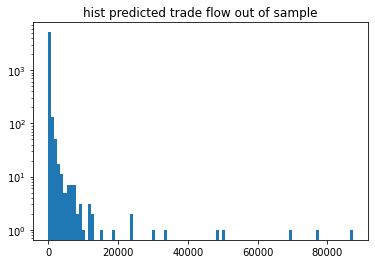

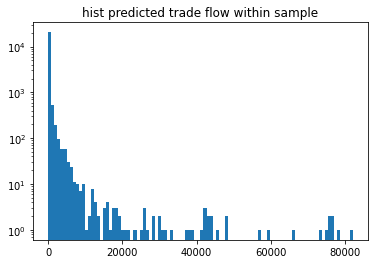

In [41]:
plt.hist(predict_oos, bins=100, log=True)
plt.title('hist predicted trade flow out of sample')
plt.show()
plt.hist(predict_wis, bins=100, log=True)
plt.title('hist predicted trade flow within sample')
plt.show()

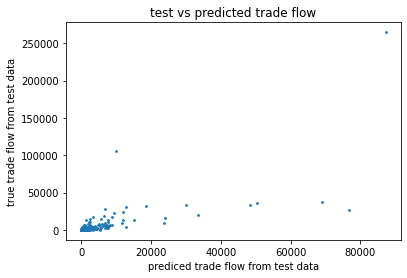

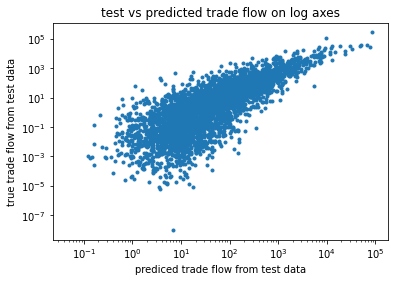

In [42]:
# plot y against y^
plt.scatter(predict_oos, data.y_test, s = 3)
plt.xlabel('prediced trade flow from test data')
plt.ylabel('true trade flow from test data')
plt.title('test vs predicted trade flow')
plt.show()
# plot y against y^ on log axes
plt.loglog(predict_oos, data.y_test, marker = 'o', markersize = 3, linestyle = '')
plt.xlabel('prediced trade flow from test data')
plt.ylabel('true trade flow from test data')
plt.title('test vs predicted trade flow on log axes')
plt.show()

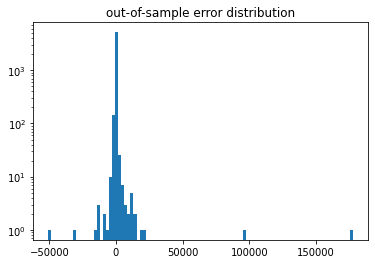

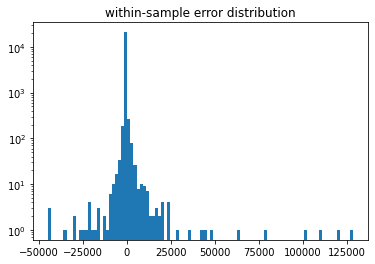

In [43]:
# out-of-sample errors
oos_errors = data.y_test - predict_oos
plt.hist(oos_errors, bins=100, log=True)
plt.title('out-of-sample error distribution')
plt.show()
# within-sample errors
is_prediction = mod.predict(params, data.X_train)
is_errors = data.y_train - is_prediction
plt.hist(is_errors, bins=100, log=True)
plt.title('within-sample error distribution')
plt.show()

random validation loop

In [20]:
all_r2_test = []
for i in range(100):
  data.tts(rnd=None)
  mod = sm.GLM(data.y_train, data.X_train, family=sm.families.Poisson())
  mod.fit(cov_type='HC1')

  predict_oos = mod.predict(params, data.X_test)
  predict_wis = mod.predict(params, data.X_train)

  cor_oos = np.corrcoef(data.y_test, predict_oos)[1][0]
  cor_wis = np.corrcoef(data.y_train, predict_wis)[1][0]
  
  r2_test = cor_oos*cor_oos
  
  all_r2_test.append(r2_test)
  print('R2 test:', r2_test)
  print('R2 train', cor_wis*cor_wis)
print('mean R2 test:', np.mean(all_r2_test))

R2 test: 0.5595509668540819
R2 train 0.506117019993818
R2 test: 0.5407344367048017
R2 train 0.49789257079823984
R2 test: 0.5892011591309668
R2 train 0.4930409749490371
R2 test: 0.5758248318499092
R2 train 0.537987050834712
R2 test: 0.44631835337281267
R2 train 0.5332638506144936
R2 test: 0.46922085819024734
R2 train 0.5187225030847982
R2 test: 0.49657934248119706
R2 train 0.5138329744244224
R2 test: 0.39361906898643034
R2 train 0.5371102301986443
R2 test: 0.6220217494816696
R2 train 0.48098838629071267
R2 test: 0.48811308604885234
R2 train 0.512423577655874
R2 test: 0.6481552256425105
R2 train 0.5183295948609847
R2 test: 0.5261707841648937
R2 train 0.506997336202984
R2 test: 0.4533152964513959
R2 train 0.5194782576048418
R2 test: 0.4678612118496203
R2 train 0.5230604069764304
R2 test: 0.531457806940581
R2 train 0.5050411157872969
R2 test: 0.5491801829223126
R2 train 0.5021369796804613
R2 test: 0.5891233541868744
R2 train 0.48437874546086984
R2 test: 0.6492978189691622
R2 train 0.502326